### QBIO465 Assignment 10
Due Thursday, April 24th before midnight (California time)

For this assignment, you are tasked with executing binary image segmentation on a collection of brain MRI scans using the U-Net architecture. The objective is to evaluate U-Net's segmentation accuracy in scenarios constrained by limited data and computational resources. This task will highlight U-Net's effectiveness in medical image analysis, particularly its ability to detect and outline abnormalities.

Most of the necessary code has been provided, serving as a reference for managing image projects in your final research. We will go through the code collectively, where you will be responsible for completing the sections that are missing.

#### Dataset
This dataset features brain MRI scans along with hand-crafted FLAIR abnormality segmentation masks. These images are sourced from The Cancer Imaging Archive (TCIA) and pertain to 110 patients from The Cancer Genome Atlas (TCGA) lower-grade glioma collection. Each patient's data includes at least one FLAIR sequence and associated genomic cluster information. More information: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data.

The dataset is featured in:  
M. Buda et al., Computers in Biology and Medicine 2019  
M. A. Mazurowski et al., Journal of Neuro-Oncology 2017

#### 1. Initialization

In [29]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate
from sklearn.metrics import confusion_matrix
import seaborn as sns

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 20


#### 2. Load data
To get the data, go to https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data. Click on "Download (749 MB)" located at the top right corner of the page to download the dataset to your local computer.

In [7]:
# Configure the path to the image files
IMAGE_PATH = '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_10/lgg-mri-segmentation/kaggle_3m/'

# A list to store the paths of each image and its corresponding mask
paths = glob.glob(os.path.join(IMAGE_PATH, '**', '*.tif'), recursive=True)

# Display the total number of paths found and a subset of these paths
len(paths), paths[:5]

(7858,
 ['/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_10/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8_mask.tif',
  '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_10/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9_mask.tif',
  '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_10/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2_mask.tif',
  '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_10/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3_mask.tif',
  '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_10/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20_mask.tif'])

In [8]:
import pandas as pd
import numpy as np
from PIL import Image

def create_data_frame(data, reduce_ratio=1):
    # Filter image and mask paths
    images = [path for path in data if not path.endswith('mask.tif')]
    masks = [path for path in data if path.endswith('mask.tif')]

    # Sort images and masks by their numerical order and patient ID
    images.sort(key=lambda x: (x.rsplit('_', 3)[-2], int(x.rsplit('_', 3)[-1][:-4])))
    masks.sort(key=lambda x: (x.rsplit('_', 3)[-3], int(x.rsplit('_', 3)[-2])))

    # Extract IDs from image paths
    IDs = [path.rsplit('\\', 3)[-1][:-4] for path in images]

    # Determine diagnosis based on the presence of non-zero pixels in masks
    diagnoses = [1 if np.max(Image.open(mask)) > 0 else 0 for mask in masks]

    # Construct the DataFrame
    df = pd.DataFrame({
        'ID': IDs,
        'Image': images,
        'Mask': masks,
        'Diagnosis': diagnoses
    })

    # Reduce the DataFrame size based on the reduce_ratio when lack of the computing resource
    if reduce_ratio < 1.0:
        df = df.sample(frac=reduce_ratio).reset_index(drop=True)

    return df

# Usage
df = create_data_frame(paths, reduce_ratio=0.1)  # Adjust 'reduce_ratio' as needed
df.head()


,ID,Image,Mask,Diagnosis
0,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
1,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
2,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
3,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
4,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0


In [9]:
df.shape

(393, 4)

#### 3. Prepare training, validation, and testing data for modeling

**Q1. Write a function named split_train_test_val that takes a DataFrame as input and splits it into three separate DataFrames: training, validation, and testing. The training set should contain 70% of the original data, the validation set 20%, and the testing set the remaining 10%. Ensure that the data is shuffled before splitting to avoid bias. Use a fixed random_state to ensure the reproducibility of your results. Return the three DataFrames in the order: training, validation, and testing. [1pt]**

In [10]:
def split_train_testing(df):
    # Making train, test, and validation dataframes
    # put your code here for Q1
    
    # shuffle the data
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # split 70:20:10
    total_size = len(df_shuffled)
    
    train_size = int(0.7 * total_size)
    val_size = int(0.2 * total_size)
    
    
    train_df = df_shuffled.iloc[:train_size].reset_index(drop=True)
    val_df = df_shuffled.iloc[train_size:train_size + val_size].reset_index(drop=True)
    test_df = df_shuffled.iloc[train_size + val_size:].reset_index(drop=True)
    

    return train_df, val_df, test_df

# Usage
train_df, val_df, test_df = split_train_testing(df)
print(len(train_df), len(val_df), len(test_df))
train_df

275 78 40


,ID,Image,Mask,Diagnosis
0,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,1
1,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
2,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
3,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
4,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
...,...,...,...,...
270,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,0
271,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,1
272,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,1
273,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,/Users/peytonhall/Documents/spring_2025/qbio_4...,1


#### 4. Vitualize the loaded data

In [11]:
def plot_images_and_masks(images, masks, predictions=None, IoU_list=None):
    num_samples = len(images)
    num_rows = 3 if predictions is not None else 2

    fig, axes = plt.subplots(num_rows, num_samples, figsize=(num_samples * 5, num_rows * 5), dpi=100)
    if num_samples == 1:  # If only one sample, axes are not an array
        axes = np.array([[axes]])
    elif num_rows == 1:  # Ensure axes is 2D if only plotting images or masks
        axes = np.array([axes])

    titles = ['Image', 'Mask', 'Prediction']
    for i in range(num_samples):
        items_to_plot = [images[i], masks[i]] + ([predictions[i]] if predictions is not None else [])
        for j, item in enumerate(items_to_plot):
            if isinstance(item, str):  # If the item is a file path
                item = Image.open(item)
            axes[j, i].imshow(item, cmap='gray')
            if j == 2 and IoU_list:  # Specific title for predictions with IoU
                title = f'{titles[j]} | IoU: {round(float(IoU_list[i]), 3)}'
            else:
                title = titles[j]
            axes[j, i].set_title(title, fontsize=15, fontweight='bold')
            axes[j, i].axis('off')

    plt.suptitle('Images, Masks, and Predictions', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()


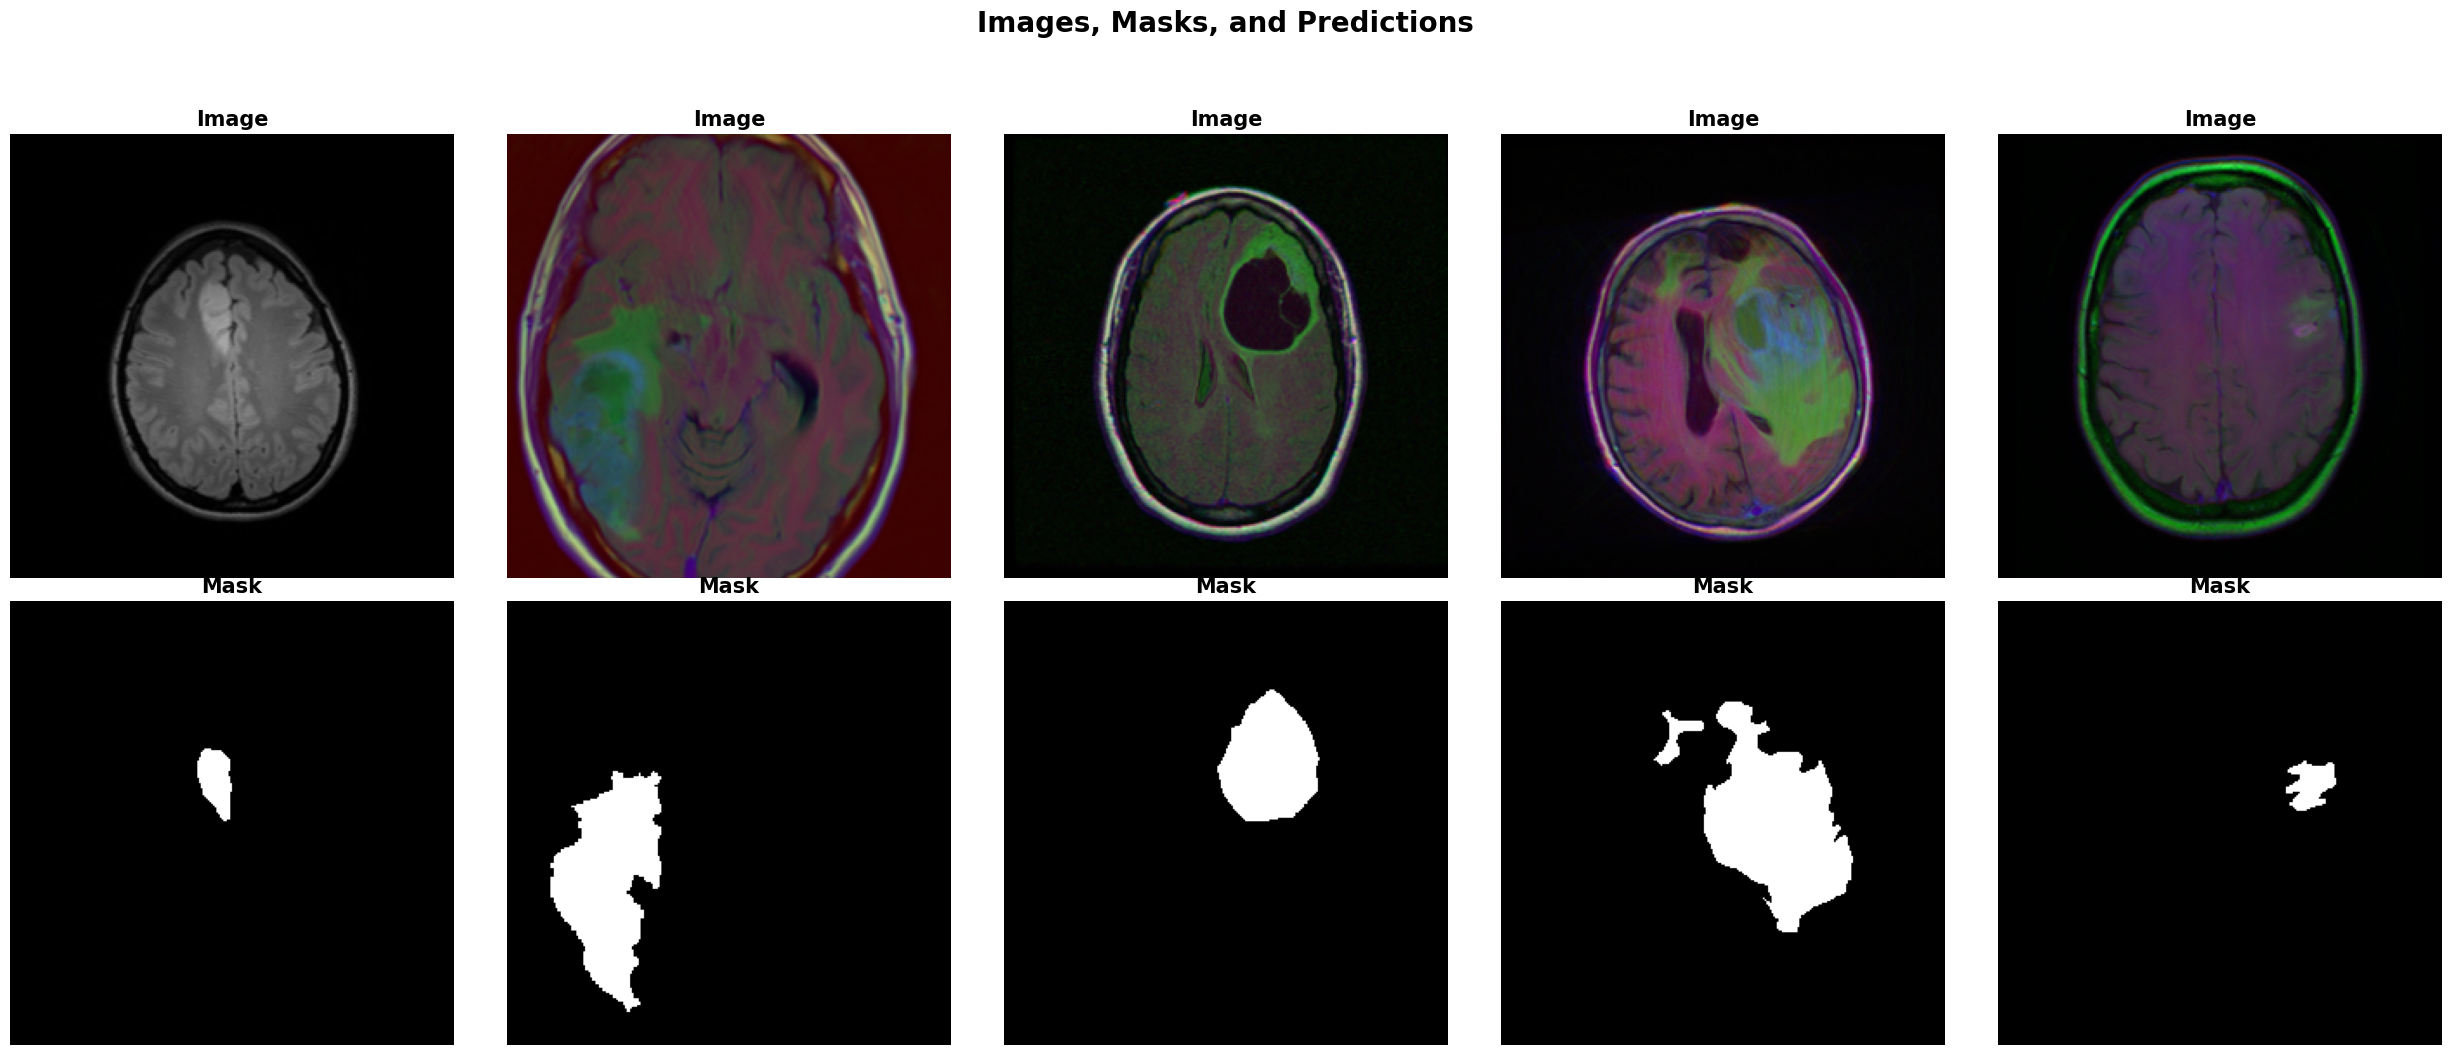

In [12]:
# Show positive cases
plot_images_and_masks(train_df[train_df['Diagnosis'] == 1]['Image'].values[:5],
                      train_df[train_df['Diagnosis'] == 1]['Mask'].values[:5])

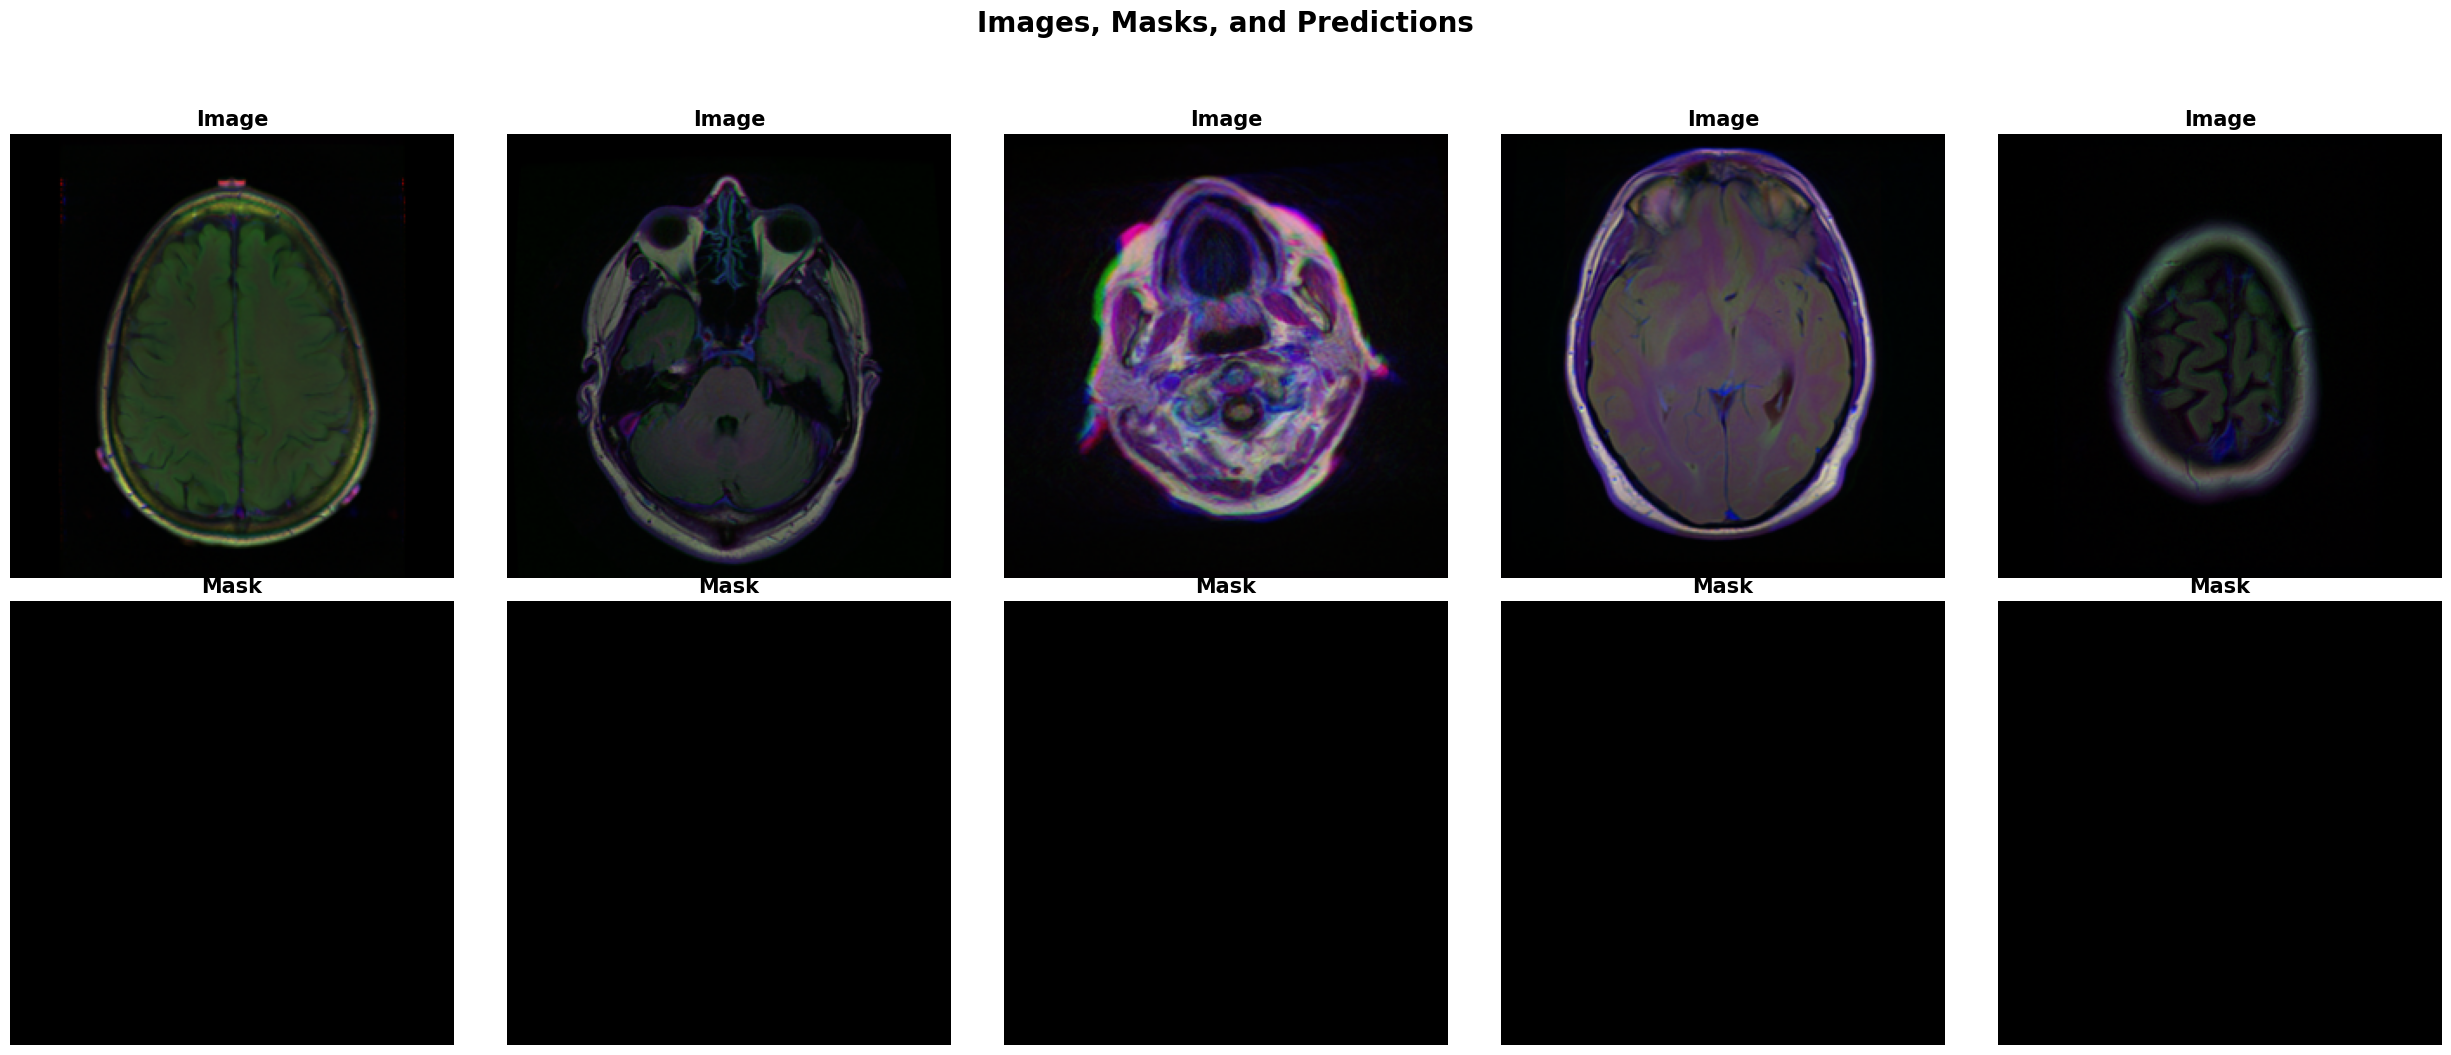

In [13]:
# Show negative cases
plot_images_and_masks(train_df[train_df['Diagnosis'] == 0]['Image'].values[:5],
                      train_df[train_df['Diagnosis'] == 0]['Mask'].values[:5])

#### 5. Formating Data for Model Input
In this step, '.tif' images are converted into tensors, resized to appropriate dimensions (images to 256x256x3 and masks to 256x256x1), and normalized by dividing by 255. The data is then structured using tf.data.Dataset.from_tensor_slices(), shuffled, matched (images to corresponding masks), and batched. Prefetching is applied to overlap data preprocessing with model training, optimizing resource usage and speeding up the process. This ensures the data is ready and optimized for model input.

In [14]:
# Loads and processes the image file.
def decode_and_resize_image(img_path):
    # Load image from TIFF file format.
    img = tf.io.read_file(img_path)
    with tf.io.gfile.GFile(img_path, 'rb') as f:
        img = Image.open(f)
        img = np.array(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE, preserve_aspect_ratio=True)

    # Scale image pixel values to [0, 1].
    img = img / 255.0

    return img

# Loads and processes the mask file.
def decode_and_resize_mask(mask_path):
    # Load mask from TIFF file format.
    mask = tf.io.read_file(mask_path)
    with tf.io.gfile.GFile(mask_path, 'rb') as f:
        mask = Image.open(f)
        mask = np.array(mask)
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)
    mask = np.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest', preserve_aspect_ratio=True)
    grayscale_mask = tf.reduce_mean(mask, axis=-1, keepdims=True)

    # Scale mask pixel values to [0, 1].
    grayscale_mask = grayscale_mask / 255.0

    return grayscale_mask


In [15]:
# Formats input images and masks for model processing.
def processed_input(img, mask):
    # Ensures images and masks are correctly shaped for the model: images as (None, 256, 256, 3), masks as (None, 256, 256, 1).
    return img, mask

# Constructs a TensorFlow dataset for model training or evaluation.
def make_dataset(images, masks):
    # Creates a dataset of image and mask pairs, applying decoding and resizing.
    dataset = tf.data.Dataset.from_tensor_slices((
        list(map(decode_and_resize_image, images)),
        list(map(decode_and_resize_mask, masks))
    ))

    # Randomly shuffles the dataset to ensure model generalization.
    dataset = dataset.shuffle(BATCH_SIZE * 8)

    # Applies formatting to each dataset item to ensure compatibility with the model input.
    dataset = dataset.map(processed_input, num_parallel_calls=tf.data.AUTOTUNE)

    # Organizes data into batches and prefetches them to improve training efficiency.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

# Prepares training and validation datasets from provided image and mask paths.
train_dataset = make_dataset(list(train_df['Image'].values), list(train_df['Mask'].values))
validation_dataset = make_dataset(list(val_df['Image'].values), list(val_df['Mask'].values))


#### 6. Build the U-Net Model

**Q2. Implement U-Net Architecture: Create a TensorFlow function named unet that implements the U-Net architecture for image segmentation. Your function should build a model to process 256x256x3 RGB images through an encoder with convolutional blocks (each containing two Conv2D layers with LeakyReLU activation and followed by MaxPool2D), a bottleneck without pooling, and a decoder with Conv2DTranspose layers for upsampling and skip connections. The model should output a single-channel segmentation mask using a Conv2D layer with a sigmoid activation. Compile the model with the Adam optimizer (learning rate 3e-4) and 'mean_squared_error' loss. Ensure you import necessary modules from TensorFlow. Your deliverable is the unet function; test it by creating a model instance and displaying its summary. [3pt]**

In [16]:
def encoder_block(inputs, num_filters):
        # first Conv2D layer
        x = Conv2D(num_filters,3, padding = 'same')(inputs)
        # LeakyReLU activation
        x = LeakyReLU(alpha=0.1)(x)
        x = BatchNormalization()(x)
        
        # second Conv2D layer
        x = Conv2D(num_filters, 3, padding = 'same')(inputs)
        # LeakyReLU activation
        x = LeakyReLU(alpha=0.1)(x)
        x = BatchNormalization()(x)
        
        # MaxPool2D
        p = MaxPool2D(pool_size=(2, 2))(x)

        return x, p


In [17]:
# decoder
# decoder with Conv2DTranspose layers for upsampling
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides = (2,2), padding = 'same')(inputs)
    x = concatenate([x,skip_features])

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters,3,padding = 'same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)

    # another conv layer
    x = Conv2D(num_filters,3,padding = 'same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)

    return x

In [18]:
def unet(input_size=(256, 256, 3)):
    
    inputs = Input(input_size)

    # skip connections
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # bottleneck without pooling
    b1 = Conv2D(1024, 3, padding = 'same')(p4)
    b1 = LeakyReLU(alpha=0.1)(b1)
    b1 = BatchNormalization()(b1)

    b1 = Conv2D(1024, 3, padding = 'same')(b1)
    b1 = LeakyReLU(alpha=0.1)(b1)
    b1 = BatchNormalization()(b1)

    # decoder block
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # single output layer
    # single-channel segmentation mask using a Conv2D layer with a sigmoid activation
    outputs = Conv2D(1,1, padding = 'same', activation='sigmoid')(d4)

    # create and compile model
    # Compile the model with the Adam optimizer (learning rate 3e-4) and 'mean_squared_error' loss. 
    model = Model(inputs, outputs, name = 'U-Net')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                 loss='mean_squared_error',
                 metrics=['accuracy'])

    model.summary()
    return model

model = unet()

/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ leaky_re_lu_5[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ leaky_re_lu_7[0]… │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 27,917,057 (106.50 MB)

 Trainable params: 27,907,201 (106.46 MB)

 Non-trainable params: 9,856 (38.50 KB)

#### 7. Train the U-Net

In [19]:
# Specifying where to store the model's best performing weights.
best_weights_path = ".weights.h5"

# Set up a callback to save only the best weights based on validation loss.
model_checkpoint = ModelCheckpoint(filepath=best_weights_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)

# Initialize EarlyStopping to halt training when validation loss ceases to decrease.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Begin model training, leveraging callbacks for checkpointing and early stopping.
history = model.fit(train_dataset, validation_data=validation_dataset,
                                   epochs=EPOCHS, callbacks=[model_checkpoint, early_stop])

# Retrieve the optimal weights once training is complete.
model.load_weights(best_weights_path)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7943 - loss: 0.1889 
Epoch 1: val_loss improved from inf to 0.73840, saving model to .weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 653s 19s/step - accuracy: 0.7964 - loss: 0.1877 - val_accuracy: 0.1367 - val_loss: 0.7384
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9415 - loss: 0.0862 
Epoch 2: val_loss improved from 0.73840 to 0.03750, saving model to .weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 710s 20s/step - accuracy: 0.9417 - loss: 0.0860 - val_accuracy: 0.9854 - val_loss: 0.0375
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9559 - loss: 0.0651 
Epoch 3: val_loss did not improve from 0.03750
35/35 ━━━━━━━━━━━━━━━━━━━━ 764s 22s/step - accuracy: 0.9558 - loss: 0.0652 - val_accuracy: 0.0298 - val_loss: 0.9665
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9684 - loss: 0.0524 
Epoch 4: val_loss did not improve from 0.03750
35/35 ━━━━━━━━━━━━━━━━━━━━ 763s 22s/step - accuracy: 0.9685

#### 8. Plot  model's performance

**Q3. Plotting Model Performance from Training History. Utilize the training history returned by model.fit to visualize the model's performance. Create plots for both the training and validation loss over each epoch. Additionally, if available, plot the accuracy metrics for both training and validation. Ensure your plots are clearly labeled with appropriate titles, axis labels, and legends. [1pt]**

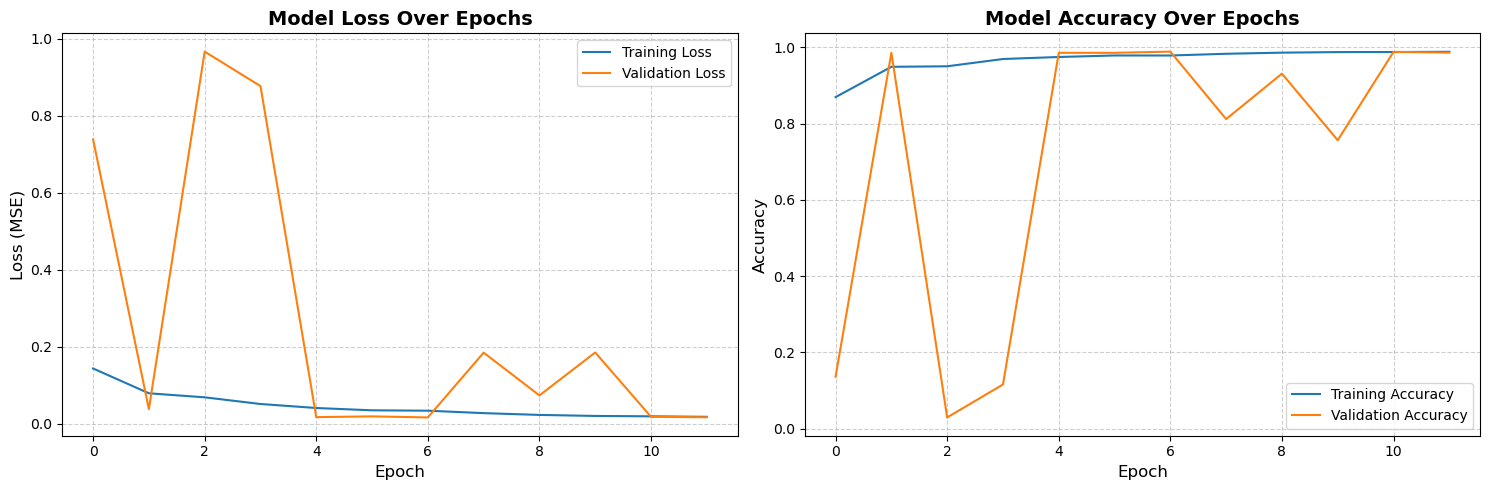

In [20]:
## put your code here for Q3
def plot_training_history(history):
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss curves
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Check if accuracy metrics are available
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        # Plot accuracy curves
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.legend(loc='lower right')
        ax2.grid(True, linestyle='--', alpha=0.6)
    else:
        # If no accuracy metrics, display a message
        ax2.text(0.5, 0.5, 'No accuracy metrics available', 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=12, transform=ax2.transAxes)
        ax2.set_title('Accuracy Metrics', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Call the function with the training history
plot_training_history(history)

#### 8. Testing
Intersection over Union (IoU) assesses the accuracy of predicted masks against actual ones by measuring their overlap. The predictions() function predicts masks from test data, converting them into binary format based on a 0.5 threshold, and calculates IoU for each to evaluate segmentation precision. It also classifies inputs as positive or negative diagnoses from these predictions.

About IoU: https://wiki.cloudfactory.com/docs/mp-wiki/metrics/iou-intersection-over-union
.

In [21]:
# Function to calculate Intersection over Union (IoU) for model evaluation.
def calculate_IoU(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    return (intersection + 1e-7) / (union + 1e-7)  # Added epsilon to prevent division by zero.

# Function to predict masks, evaluate them with IoU, and compile results into a DataFrame.
def evaluate_predictions(dataframe, threshold=0.5):
    image_arrays = np.array([decode_and_resize_image(path) for path in dataframe['Image']])
    true_masks = np.array([decode_and_resize_mask(path) for path in dataframe['Mask']])

    predicted_masks = model.predict(image_arrays)
    predicted_masks_thresholded = (predicted_masks > threshold).astype(float)

    IoU_scores = calculate_IoU(true_masks, predicted_masks_thresholded).numpy()
    IoU_scores = [round(score, 3) for score in IoU_scores]

    # Determine the binary diagnosis based on the presence of mask pixels
    predicted_diagnoses = [1 if np.max(mask) > 0 else 0 for mask in predicted_masks_thresholded]

    results_df = pd.DataFrame({
        'ID': dataframe['ID'],
        'Actual Diagnosis': dataframe['Diagnosis'],
        'Predicted Diagnosis': predicted_diagnoses,
        'IoU': IoU_scores
    })

    # Creating a dictionary to map each ID to its predicted mask
    predicted_masks_dict = {ID: mask for ID, mask in zip(dataframe['ID'], predicted_masks_thresholded)}

    return predicted_masks_dict, results_df

# Utilize the function to get predictions and compile results
predicted_masks, results_dataframe = evaluate_predictions(test_df)

# Display outputs
print(f"Total Predictions: {len(predicted_masks)}, Example Mask Shape: {next(iter(predicted_masks.values())).shape}")
results_dataframe.head()


2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step
Total Predictions: 40, Example Mask Shape: (256, 256, 1)


,ID,Actual Diagnosis,Predicted Diagnosis,IoU
0,/Users/peytonhall/Documents/spring_2025/qbio_4...,0,0,1.0
1,/Users/peytonhall/Documents/spring_2025/qbio_4...,0,1,0.0
2,/Users/peytonhall/Documents/spring_2025/qbio_4...,0,0,1.0
3,/Users/peytonhall/Documents/spring_2025/qbio_4...,0,0,1.0
4,/Users/peytonhall/Documents/spring_2025/qbio_4...,1,0,0.0


In [22]:
results_dataframe.describe()

,Actual Diagnosis,Predicted Diagnosis,IoU
count,40.000000,40.000000,40.000000
mean,0.250000,0.100000,0.751900
std,0.438529,0.303822,0.424256
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.625250
50%,0.000000,0.000000,1.000000
75%,0.250000,0.000000,1.000000
max,1.000000,1.000000,1.000000


**Q4. Extract the actual and predicted diagnoses from results_dataframe.
Use the extracted data to calculate the confusion matrix. You are encouraged to utilize scikit-learn's confusion_matrix function for this task. [2pt]**

In [32]:
# put your code here for Q4
def plot_confusion_matrix(results_df):
    # extract actual and predicted diagnoses from results df
    y_true = results_df['Actual Diagnosis']
    y_pred = results_df['Predicted Diagnosis']
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # figure for plotting
    plt.figure(figsize=(8, 6))
    
    # plot confusion matrix as heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.tight_layout()
    plt.show()

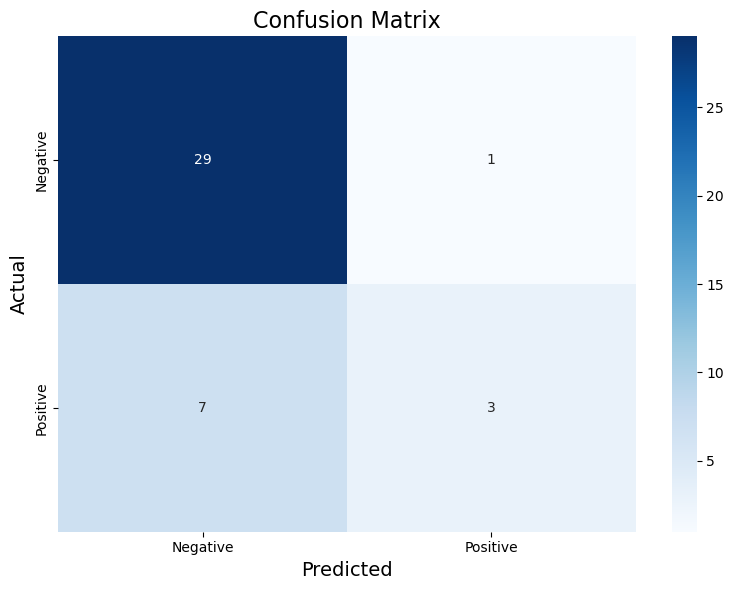

In [33]:
plot_confusion_matrix(results_dataframe)